In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv
/kaggle/input/pubg-finish-placement-prediction/train_V2.csv


In [2]:
data=pd.read_csv('../input/pubg-finish-placement-prediction/train_V2.csv')

## Let's understand the tips and tricks to get a chicken dinner in PUBG.


### Let's have a look at the dataset

In [3]:
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


### Dropping the rankPoints column as this ranking is inconsistent and is being deprecated in the API’s next version.

In [5]:
data.drop(columns='rankPoints', inplace=True)

In [6]:
data.head(1)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,...,0,0.0,0,0.0,0,0,244.8,1,1466,0.4444


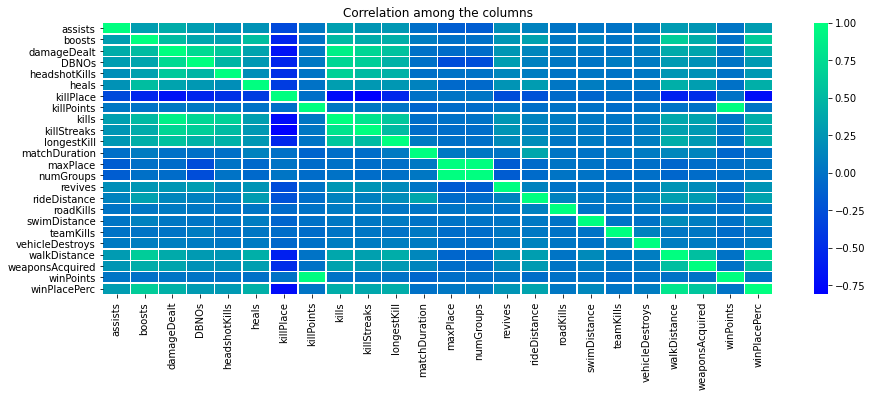

In [7]:
plt.subplots(figsize=(15,5))
sns.heatmap(data.corr(),linewidth=0.5,cmap='winter')
plt.title('Correlation among the columns')
plt.show()

### Inferences drawn:
1. Walk Distance is highly correlated with Win Place
2. Kill Points and win points is highly correlated
3. Walk distance and Win place has high correlation
4. Kill place has a high negative correlation with Win Place,kill streaks, damage dealt and boosts
5. Kills have quite a high amount correlation with damage dealt


In [8]:
won=data['winPlacePerc']==1
lost=data['winPlacePerc']==0
a=data[won|lost]
a['winPlacePerc']=a['winPlacePerc'].astype('str')
a


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.00,0,0,0,96,...,0,0.0,0,0.0,0,0,13.500,1,1497,0.0
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.00,0,0,0,87,...,0,0.0,0,0.0,0,0,0.000,0,0,0.0
62,eea397f23204bd,19650a810dbdbf,b99cd2f850c233,0,0,100.00,1,0,0,41,...,0,0.0,0,0.0,0,0,9.907,1,1514,0.0
67,22252be49d4419,37fa7583da2fa2,1ce1cb998f75c7,1,5,378.80,2,3,6,4,...,0,317.7,0,0.0,0,1,3120.000,4,0,1.0
74,8b3cdbefd1f408,d25fc68b94f38c,128c05e4e54c63,0,0,0.00,0,0,0,91,...,0,0.0,0,0.0,0,0,27.060,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446906,c93d4f3ca3910a,9a8b358f64502a,7268767186117f,0,0,0.00,0,0,0,96,...,0,0.0,0,0.0,0,0,41.940,0,0,0.0
4446919,15758e053bb81b,c4b5fc72a74386,1ffa105aa4f5f6,0,0,42.81,0,0,0,93,...,0,0.0,0,0.0,0,0,15.700,1,0,0.0
4446926,e0c791ea3c4644,e18240dcce54f9,827639896a20cb,0,0,0.00,0,0,0,87,...,0,0.0,0,0.0,0,0,0.000,0,916,0.0
4446942,2c9f1610de0ecd,d64a0663e96058,5c9254fa96f53e,0,4,724.70,6,4,14,1,...,3,5076.0,0,0.0,0,0,2162.000,8,0,1.0


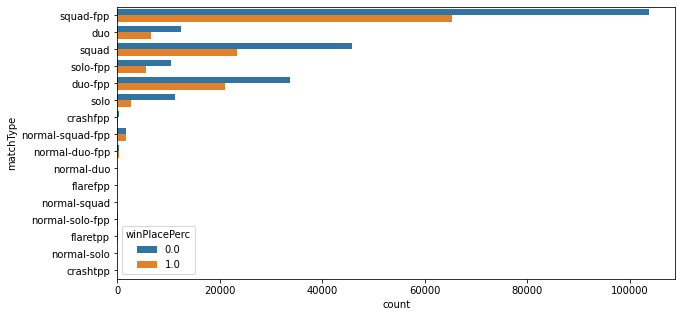

In [9]:
plt.subplots(figsize=(10,5))
sns.countplot(y='matchType',hue='winPlacePerc',data=a)


### Inferences drawn
1. Squad-fpp is the most popular game but here the chances of losing is also maximum.


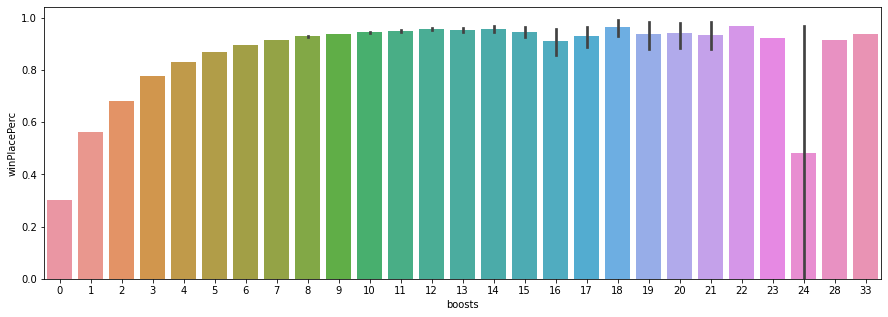

In [10]:
plt.subplots(figsize=(15,5))
sns.barplot(x='boosts',y='winPlacePerc', data=data)


### Inferences drwan:
It is obvious that higher you boost yourself, the longer you will survive and might win the game finally.

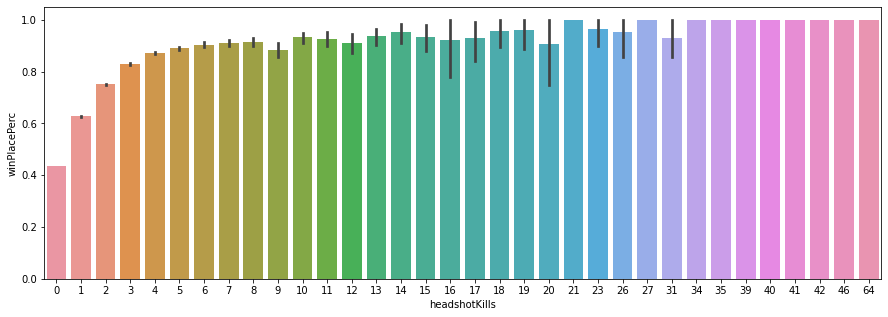

In [11]:
plt.subplots(figsize=(15,5))
sns.barplot(x='headshotKills',y='winPlacePerc', data=data)



### Inferences drawn
The higher the head shot kills, more is the chances of winning.

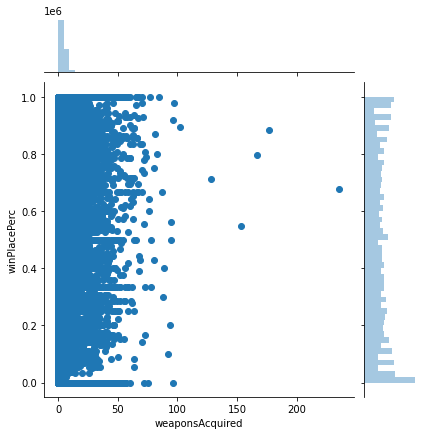

In [12]:

sns.jointplot(x='weaponsAcquired',y='winPlacePerc' ,data=data)


### Don't try to acquire unnecessary weapons. Acquire as much as required.

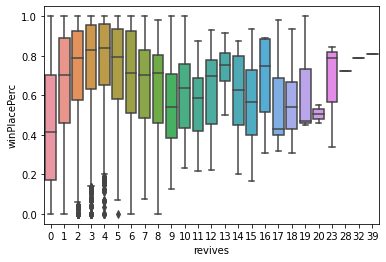

In [13]:
sns.boxplot(x='revives',y='winPlacePerc',data=data)


### Reviving few teammates may help

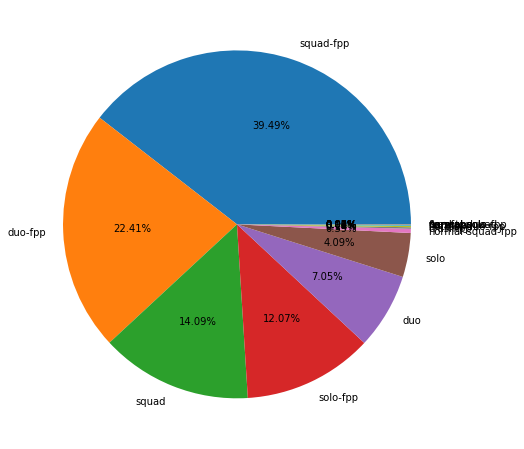

In [14]:
plt.subplots(figsize=(20,8))
a=data['matchType'].value_counts().to_frame().reset_index()
b=a['index'].to_list()
c=a['matchType'].to_list()
plt.pie(c,labels=b, autopct="%0.2f%%")
plt.show()

### The most popular game is squad-fpp, followed by duo-fpp, followed by squad.

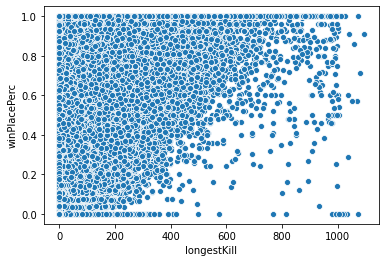

In [15]:
sns.scatterplot(x='longestKill',y='winPlacePerc', data=data)


A distance greater than 400 between you and the player killed can give you a more sureshot chance of winning the match.

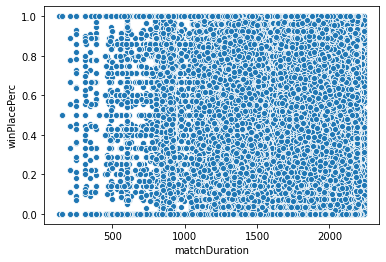

In [16]:
sns.scatterplot(x='matchDuration',y='winPlacePerc', data=data)


No such conclusion can be drawn.

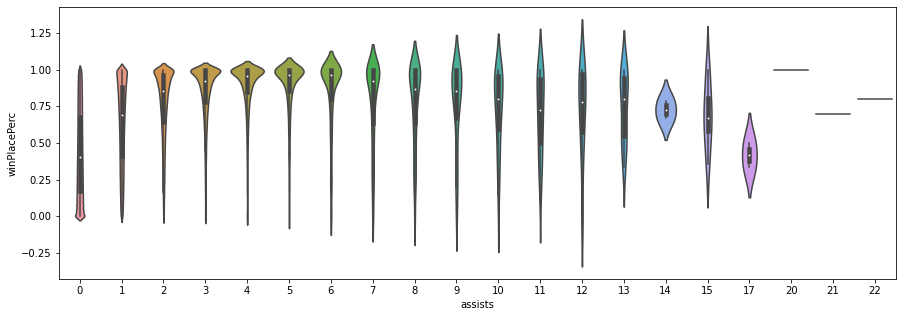

In [17]:
plt.subplots(figsize=(15,5))
sns.violinplot(x='assists',y='winPlacePerc', data=data)

Not a significant relationship

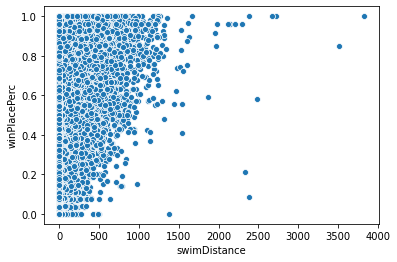

In [18]:
sns.scatterplot(x='swimDistance',y='winPlacePerc', data=data)

Swimming diatance between a range of 800-1300 is preferable for getting success. 

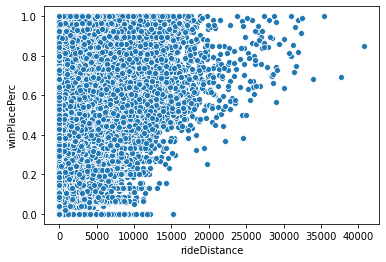

In [19]:
sns.scatterplot(x='rideDistance',y='winPlacePerc', data=data)

No such relation








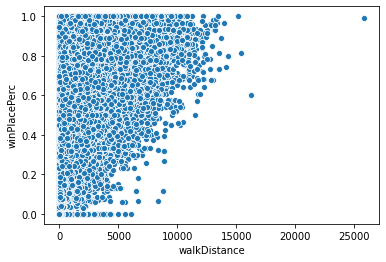

In [20]:
sns.scatterplot(x='walkDistance',y='winPlacePerc', data=data)

Walking diatance between a range of 1000-1400 is preferable for getting success.








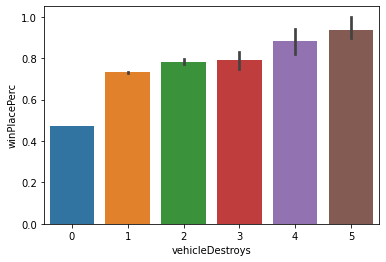

In [21]:
sns.barplot(x='vehicleDestroys',y='winPlacePerc', data=data)

### Destroy more vehicles.

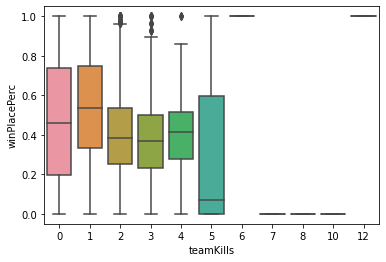

In [22]:
sns.boxplot(x='teamKills', y='winPlacePerc', data=data)

### Avoid killing your teammates.

### Conclusion:
1. Boost yourself because the longer you survive, higher the chances of winning the game finally.
2. Head shoot your enemy. The higher the head shot kills, more is the chances of winning.
3. Don't try to acquire unnecessary weapons. Acquire as much as required.
4. Reviving few teammates may help
5. The most popular game is squad-fpp, followed by duo-fpp, followed by squad.
6. A distance greater than 400 between you and the player killed can give you a more sureshot chance of winning the match.
7. Walking diatance between a range of 1000-1400 is preferable for getting success.

8. Destroy more vehicles.

9. Avoid killing your teammates.


